<a href="https://colab.research.google.com/github/monta0315/DGM-and-VR/blob/main/VR/Segmentation_Pra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FCN(Fully Convolutinal Network)を実装し、VOC2011データセットに対しセグメンテーションを実行する

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from torchvision.datasets import VOCSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#VOCデータセットは画像認識用のデータセットで
#Classfication
#Segmentation
#Object detection
#で利用することができる

#Segmentationタスク用には入力画像とSegmentation maskが提供されている　=>　正解ラベルってこと？？

  0%|          | 0/1765686784 [00:00<?, ?it/s]

Extracting ./VOCSegmentation/2011/VOCtrainval_25-May-2011.tar to ./VOCSegmentation/2011


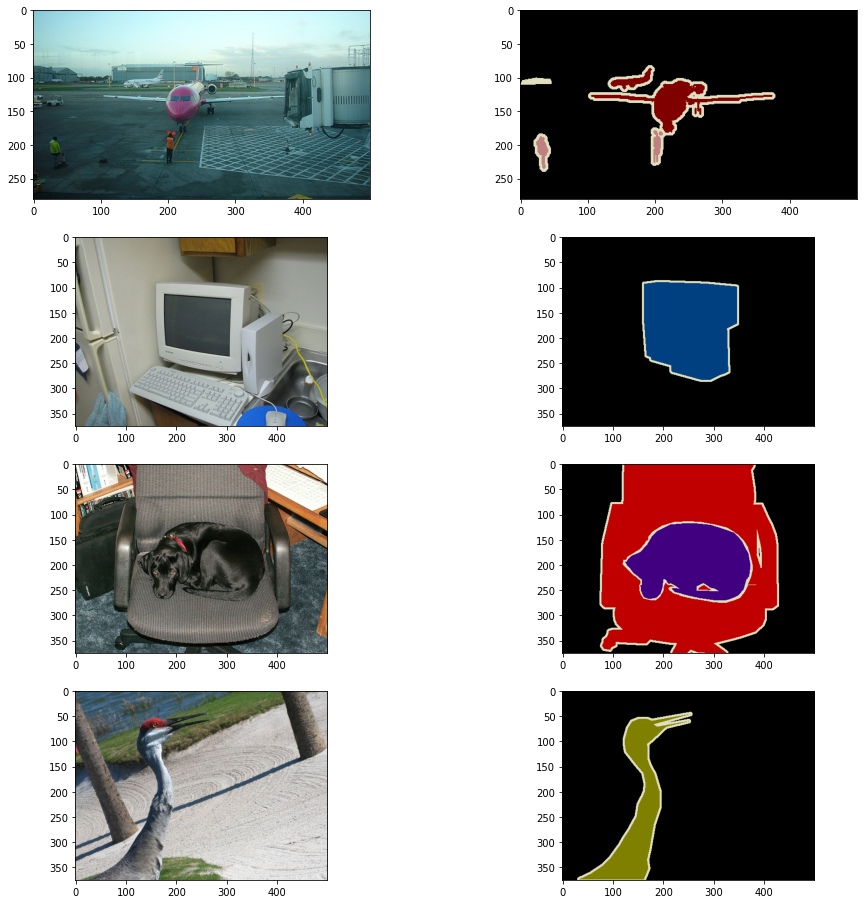

In [ ]:
#VOC2011の可視化
train_dataset = VOCSegmentation(root="./VOCSegmentation/2011",year="2011",image_set="train",download=True)

plt.figure(figsize=(16,16))
for i in range(4):
  image,target = train_dataset[i]
  plt.subplot(4,2,2*i+1)
  plt.imshow(image)
  plt.subplot(4,2,2*i+2)
  plt.imshow(target)

VOCデータセットに以下の前処理を施す

- (224,224)へのリサイズ
- 境界線に対応するクラス(255)の除去
- クラスラベルのone-hot encoding

torch.Size([16, 21, 224, 224])


In [ ]:
batch_size = 16
num_classes = 21

#permuteは軸の順番の入れ替えを行なっている
#numpyの配列に変更するのはその後の変形やTensorへの変形をしやすくするため？

#前処理の定義
def TargetToTensor(target):
  target = np.array(target)
  target[target>20]=0 #labelを0~20の合計21クラスに限定
  target = torch.from_numpy(target).type(torch.long) #numpy配列に入っているものをTensorに変更
  target = F.one_hot(target,num_classes=num_classes).permute(2,0,1).type(torch.float)
  return target

image_transform = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor()
])

target_transform = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.Lambda(lambda target: TargetToTensor(target))
])

#datasetの定義
train_dataset = VOCSegmentation(root="./VOCSegmentation/2011",year="2011",
                                image_set="train",download=True,
                                transform=image_transform,
                                target_transform=target_transform)
valid_dataset = VOCSegmentation(root="./VOCSegmentation/2011",year = "2011",
                                image_set="val",download=True,
                                transform=image_transform,
                                target_transform=target_transform)

#dataloaderの定義
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)




Using downloaded and verified file: ./VOCSegmentation/2011/VOCtrainval_25-May-2011.tar
Extracting ./VOCSegmentation/2011/VOCtrainval_25-May-2011.tar to ./VOCSegmentation/2011
Using downloaded and verified file: ./VOCSegmentation/2011/VOCtrainval_25-May-2011.tar
Extracting ./VOCSegmentation/2011/VOCtrainval_25-May-2011.tar to ./VOCSegmentation/2011


2.FCNの実装

FCNは以下の二段階に分かれる
- 既存の画像認識モデル(backbone)による特徴抽出
- ConvolutionalとUpscaleによるピクセル単位の予測

今回はbackboneとして以下のモデルを採用
- ResNet50
- GAP層とFC層を外し、特徴抽出機とする

入出力(CHW)は以下のようになる
- 入力:(3,224,224)
- 出力:(2048,7,7)

In [ ]:
#backboneの作成
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-2])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FCNは以下の手順で予測を出力する
- Convolutinal: backboneで得られた特徴をクラス数のchannelに変換
- Upscale: スケールが元画像と一致するように変換して予測とする

今回はそれぞれを以下のように実装します
- Convlutional: FCNhead
  - Conv2d(input_channel,input_channel//4,3,padding=1,bias=False)
  - BatchNorm2d
  - ReLU
  - Dropout(0.1)
  - Conv2d(input_channel//4,num_classes,1)
- Upscale: F.interpolate(c,size=input_size,mode="bilinear",align_corners=False)

In [ ]:
# FCNの定義 
class FCN(nn.Module):
    def __init__(self, backbone, num_classes=21):
        super(FCN, self).__init__()
        self.backbone = backbone
        self.FCNhead = nn.Sequential(nn.Conv2d(2048, 512, 3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(),
                                      nn.Dropout(0.1),
                                      nn.Conv2d(512, num_classes, 1))

    def forward(self, x):
        input_shape = x.shape[-2:] # shape: (224, 224)
        x = self.backbone(x)
        x = self.FCNhead(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return {'out': x}

#FCNの学習
以上を実装したFCNをVOCデータセットに対して学習させます

In [ ]:
#modelの作成
model = FCN(backbone=resnet50,num_classes=num_classes)
model.to(device)

FCN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

損失関数：BinaryCrossEntropy

評価指数：mean-IoU

オプティマイザ：AdamW

In [ ]:
class mIoUScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou)
        return mean_iou

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [ ]:
#optimizer,loss function, metricsの定義
loss_fn = nn.BCEWithLogitsLoss()
metrics = mIoUScore(num_classes)
optimizer = optim.AdamW(model.parameters(),lr=1e-4,weight_decay=1e-3)

In [ ]:
n_epochs = 5

# modelの学習
for epoch in range(n_epochs):
    train_losses = []
    valid_losses = []
    metrics.reset()
    
    model.train()
    with tqdm(total=len(train_dataloader), unit="batch") as pbar:
        pbar.set_description(f"[train] Epoch {epoch+1}/{n_epochs}")
        for image, target in train_dataloader:
            optimizer.zero_grad()
            image, target = image.to(device), target.to(device)
            output = model(image)['out']
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pbar.set_postfix(loss=np.array(train_losses).mean())
            pbar.update(1)

    model.eval()
    with tqdm(total=len(valid_dataloader), unit="batch") as pbar:
        pbar.set_description(f"[valid] Epoch {epoch+1}/{n_epochs}")
        for image, target in valid_dataloader:
            image, target = image.to(device), target.to(device)
            output = model(image)['out']
            loss = loss_fn(output, target)
            valid_losses.append(loss.item())
            metrics.update(target.argmax(1).cpu().numpy(), output.argmax(1).cpu().numpy())
            pbar.set_postfix(loss=np.array(valid_losses).mean(), mIoU=metrics.get_scores())
            pbar.update(1)

[valid] Epoch 5/5: 100%|██████████| 70/70 [00:27<00:00,  2.51batch/s, loss=0.0546, mIoU=0.465]


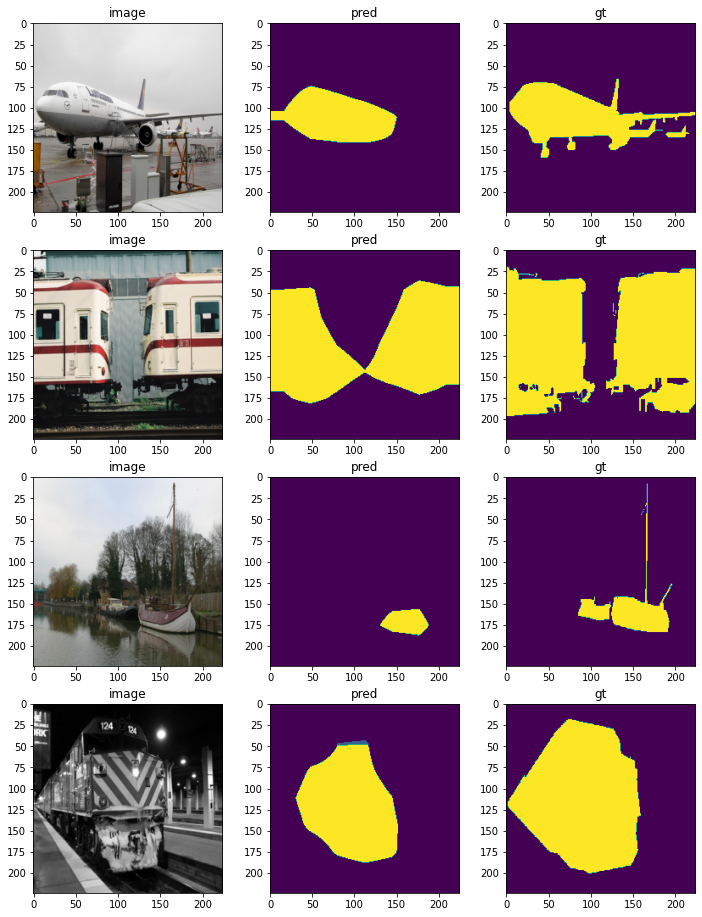

In [ ]:
#予測の可視化

plt.figure(figsize=(12,16))
model.eval()
for i in range(4):
    image,target = valid_dataset[i]
    pred = model(image.to(device).unsqueeze(0))['out']
    plt.subplot(4,3,3*i+1)
    plt.title("image")
    plt.imshow(image.numpy().transpose(1,2,0))
    plt.subplot(4,3,3*i+2)
    plt.title("pred")
    plt.imshow(pred.argmax(1).cpu().numpy()[0])
    plt.subplot(4,3,3*i+3)
    plt.title("gt")
    plt.imshow(target.argmax(0).cpu().numpy())